# Assignment 6 vj222hx

Loading and plotting the MNIST dataset

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


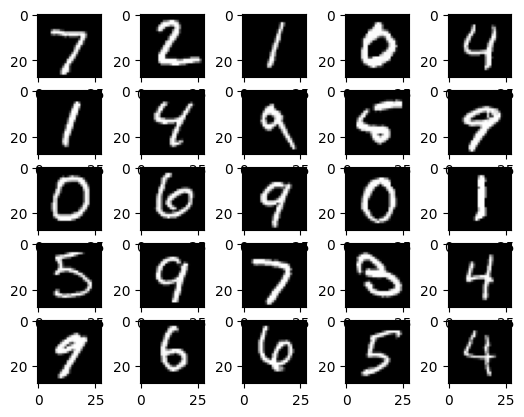

In [239]:
from tensorflow.keras.datasets.mnist import load_data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = load_data()

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape)) 
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_test[i], cmap=plt.get_cmap('gray'))

plt.show()

Setting the sceene for image classification

In [290]:
from numpy import zeros
from numpy import unique
from numpy import argmax
from numpy import asarray
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import Input

In [241]:
orig_shape = x_train.shape[1:]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
in_shape = x_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

Before: (28, 28)
After: (28, 28, 1)


In [242]:
n_classes = len(unique(y_train)) 
print("Classes: {0}".format(n_classes))

Classes: 10


In [243]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [279]:
EPOCHS = 10
BATCH_SIZE = 128
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=10,
    mode='max', 
    restore_best_weights=True)
it = round(60000/BATCH_SIZE)

In [280]:
def plot_metrics(history):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
    metrics = ['loss', 'accuracy'] 
    plt.figure(figsize=(10,5))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(1,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0],label='Train')
        plt.plot(history.epoch, history.history['val_'+ metric],color=colors[0], linestyle="--", label='Val') 
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1] +0.1]) 
        else:
            plt.ylim([-0.1,1.1])
        plt.legend()

In [281]:
def print_res(model): 
    err = 0
    i_range = 10
    ys = zeros(i_range * i_range) 
    class bcolors:
        FAIL = '\033[91m'
        ENDC = '\033[0m' 
    for i in range(i_range):
        for j in range(i_range):
            idx = i*i_range+j
            image = x_test[idx]
            yhat = model.predict(asarray([image]))
            ys[idx] = argmax(yhat) 
            print('%d ' % ys[idx], end = '')
        print()
    print("--")
    for i in range(i_range): 
        for j in range(i_range):
            idx = i*i_range+j; 
            y = y_test[idx] 
            if y==ys[idx]:
                print('%d ' % y, end = '')
            else:
                err = err + 1
                print(f"{bcolors.FAIL}%d {bcolors.ENDC}" % y, end = '') 
        print()
    return err

## Model without data augmentation

I will begin by tuning the parameters without data augmentation. I will do this by reducing the parameter count in the dense layer and add it to the CNN layer and playing around with the pooling layer. I will also try adding a nother CNN and pooling layer and tuning the parameters here. I do this because the dense layer has a lot of parameters per points of accuracy increase and then I will use the other parts to compensate. 

In [316]:
def make_model1(add_dense=False):
    model = Sequential()
    model.add(Input(shape=in_shape))
    model.add(Conv2D(32, (9, 9), activation='relu'))
    model.add(MaxPooling2D((4, 4)))
    model.add(Flatten())
    if add_dense:
        model.add(Dense(30, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

model = make_model1(False)
model.summary()

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 20, 20, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 10)             │         8,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,634 (41.54 KB)

 Trainable params: 10,634 (41.54 KB)

 Non-trainable params: 0 (0.00 B)

In [317]:
model_history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8109 - loss: 0.7441 - val_accuracy: 0.9720 - val_loss: 0.1055
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9721 - loss: 0.1010 - val_accuracy: 0.9789 - val_loss: 0.0692
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9779 - loss: 0.0718 - val_accuracy: 0.9824 - val_loss: 0.0586
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9821 - loss: 0.0607 - val_accuracy: 0.9863 - val_loss: 0.0449
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9852 - loss: 0.0501 - val_accuracy: 0.9866 - val_loss: 0.0415
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9870 - loss: 0.0428 - val_accuracy: 0.9875 - val_loss: 0.0408
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9885 - loss: 0.0390 - val_accuracy: 0.9888 - val_loss: 0.0333
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9895 - loss: 0.0366 - val_accuracy: 0.

Accuracy: 0.990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

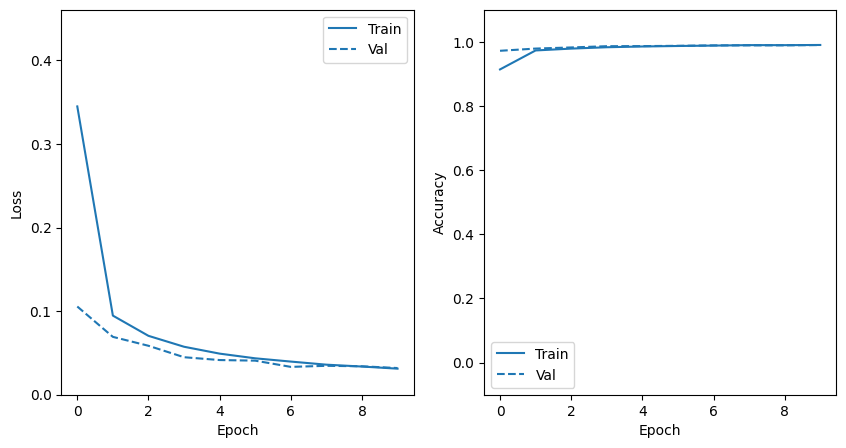

In [318]:
plot_metrics(model_history)
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)
err = print_res(model)

After playing around with parameters I found that the dense layer has very little impact so I removed it all together. For the other parameters I found that having a depth of 32, a CNN kernel width of 9 and a pool stride of 4 gave a good result, giving me an accuracy of 0.990 with a parameter count of 10634 which is roughly 50x less than the teacher. Adding an additional layer added parameter count with no increase in accuracy

## Model with data augmentation

When adding data augmentation I might have to add parameters and potentially bring back the dense layer to compensate for a wider variaty of data. Data augmentation takes the training data and adds variation to it by applying random zoom, rotation and flips it. This creates a lot of new training data to hopefully improve performance.  

In [340]:
def make_model2(add_dense=False):
    model = Sequential()
    model.add(Input(shape=in_shape))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D((4, 4)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    if add_dense:
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

# 32, 7, 4
model = make_model2(True)
model.summary()

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 24, 24, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 4, 4, 16)       │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_55 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,406 (71.90 KB)

 Trainable params: 18,406 (71.90 KB)

 Non-trainable params: 0 (0.00 B)

In [341]:
# data Augmentation
datagen = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=10,
    horizontal_flip=True
)

train_generator = datagen.flow(x_train, y_train, batch_size=16)

model_history = model.fit(
    train_generator,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.7406 - loss: 0.7606 - val_accuracy: 0.9522 - val_loss: 0.1501
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9345 - loss: 0.2145 - val_accuracy: 0.9724 - val_loss: 0.0807
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9487 - loss: 0.1637 - val_accuracy: 0.9744 - val_loss: 0.0719
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9583 - loss: 0.1346 - val_accuracy: 0.9799 - val_loss: 0.0639
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9625 - loss: 0.1213 - val_accuracy: 0.9815 - val_loss: 0.0557
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9664 - loss: 0.1105 - val_accuracy: 0.9810 - val_loss: 0.0648
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9685 - loss: 0.1041 - val_accuracy: 0.9830 - val_loss: 0.0553
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9680 - loss: 0

Accuracy: 0.984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

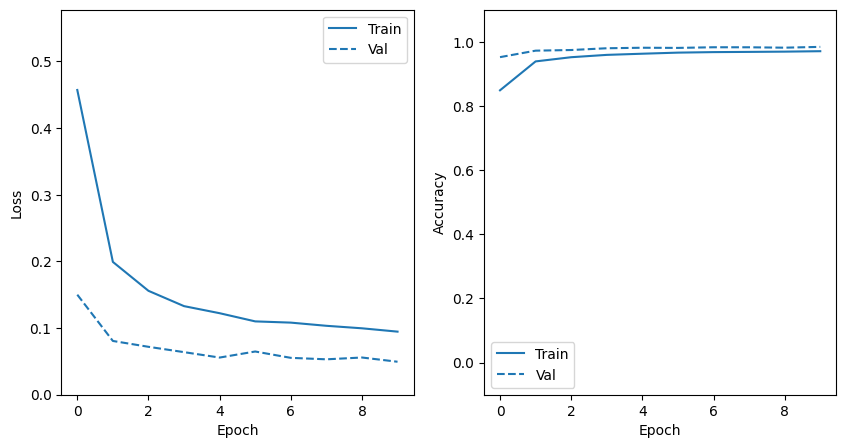

In [342]:
plot_metrics(model_history)
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)
err = print_res(model)

When using data augmentation I didn't manage to get as good of an accuracy and it is using more parameters. However the best score I managed to get does use two CNN layers with different parameters and the dense layer.